PM_980 DATASET FOR SIGNAL CLASSIFICATION  "01"


Name Surname : Kaan ERDEN   Student ID : 211805068

In [ ]:
import os
import glob
import re
import time
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib 


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

Import 

In [ ]:


DATA_PATH = "./PM980/"
SAMPLING_RATE = 90

SENSOR_COLUMNS = [
    'Voice', 'Acceleration X', 'Acceleration Y', 'Acceleration Z',
    'Gyro X', 'Gyro Y', 'Gyro Z', 'Temperature'
]

def load_data(data_path, sensor_columns):
    raw_segments = []
    speed_intervals = []
    labels = []
    filenames = []
    csv_files = glob.glob(os.path.join(data_path, "*.csv"))
    if not csv_files:
        print(f"Uyarı: {data_path} klasöründe hiç CSV dosyası bulunamadı.")
        return raw_segments, speed_intervals, labels, filenames
    print(f"Toplam {len(csv_files)} CSV dosyası bulundu.")
    for f_path in csv_files:
        filename = os.path.basename(f_path)
        filenames.append(filename)
        try:
            parts = filename.split('_')
            hiz1 = float(parts[0])
            hiz2 = float(parts[1])
            label_from_file = parts[2] 
            df = pd.read_csv(f_path, header=0)
            segment_data = df[sensor_columns].values
            raw_segments.append(segment_data)
            speed_intervals.append([hiz1, hiz2])
            labels.append(label_from_file) 
        except Exception as e:
            print(f"Hata: {filename} dosyası işlenirken sorun oluştu: {e}")
    return raw_segments, np.array(speed_intervals), labels, filenames

raw_segments, speed_intervals, original_labels, loaded_filenames = load_data(DATA_PATH, SENSOR_COLUMNS)


def remap_labels(original_labels):
    remapped_labels = []
    target_classes_non_healthy = [
        "scracth", "notchshort", "notchlong", "singlecutlong",
        "singlecutshort", "twocutlong", "twocutshort", "warped"
    ]
    for label in original_labels:
        if label.startswith("healthy"):
            remapped_labels.append("healthy")
        elif label in target_classes_non_healthy:
            remapped_labels.append(label)
        else:
            
            print(f"Uyarı: Beklenmedik etiket '{label}' bulundu. 'healthy' olarak eşleniyor.")
           
            remapped_labels.append("healthy") 
    return remapped_labels

if original_labels:
    labels = remap_labels(original_labels) 

    print(f"\nBaşarıyla yüklenen segment sayısı: {len(raw_segments)}")
    if raw_segments:
      print(f"İlk segmentin boyutu (satır, sütun): {raw_segments[0].shape}")
    print(f"İlk hız aralığı: {speed_intervals[0]}")
    print(f"İlk orijinal etiket: {original_labels[0]}, Düzenlenmiş etiket: {labels[0]}")

    
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nDüzenlenmiş Sınıf Dağılımı (Hedef 9 Sınıf):")
    for label_name, count in zip(unique_labels, counts):
        print(f"- {label_name}: {count}")
    print(f"Toplam farklı sınıf sayısı: {len(unique_labels)}")

else:
    print("Veri yüklenemedi.")

Toplam 480 CSV dosyası bulundu.

Başarıyla yüklenen segment sayısı: 480
İlk segmentin boyutu (satır, sütun): (273, 8)
İlk hız aralığı: [100. 110.]
İlk orijinal etiket: healthynotchlong, Düzenlenmiş etiket: healthy

Düzenlenmiş Sınıf Dağılımı (Hedef 9 Sınıf):
- healthy: 240
- notchlong: 30
- notchshort: 30
- scracth: 30
- singlecutlong: 30
- singlecutshort: 30
- twocutlong: 30
- twocutshort: 30
- warped: 30
Toplam farklı sınıf sayısı: 9




In this part, I loaded the raw sensor data from the `./PM980/` folder. The data files are all CSV format and include 8 sensor columns like Voice, Acceleration (X, Y, Z), Gyro (X, Y, Z), and Temperature. I also extracted speed intervals from the filenames (they are given as two float values) and the label of the sample.

While loading, if there’s any issue with a file (like wrong format), the script prints an error but keeps processing the rest.

After loading, I remapped the labels. The dataset has different types of labels for non-healthy conditions like `scratch`, `notchshort`, `twocutlong`, etc. I grouped all healthy ones under a single label called `"healthy"` and kept the others as they are. If an unknown label appears, I also assign it as `"healthy"` just to be safe.

Finally, I printed some sample data like the shape of the first segment, the speed range, original and new label, and also the distribution of the final 9 classes.


In [ ]:

def extract_features_segment(segment_data, speed_interval, sampling_rate):
    features = []
    features.extend(speed_interval)
    features.append(speed_interval[1] - speed_interval[0])
    num_samples, num_sensors = segment_data.shape

    if num_samples == 0:
        
        num_time_voice = 9
        num_time_other = 8
        num_freq_all = 5
        
        _feature_names_temp = get_feature_names(SENSOR_COLUMNS) 
        num_total_features_expected = len(_feature_names_temp)
        return features + [0] * (num_total_features_expected - len(features))


    for i in range(num_sensors):
        sensor_signal = segment_data[:, i]
        sensor_name = SENSOR_COLUMNS[i]

        features.append(np.mean(sensor_signal))
        features.append(np.std(sensor_signal))
        features.append(np.min(sensor_signal))
        features.append(np.max(sensor_signal))
        features.append(np.median(sensor_signal))
        features.append(skew(sensor_signal))
        features.append(kurtosis(sensor_signal))
        features.append(np.sqrt(np.mean(sensor_signal**2))) # RMS

        if sensor_name == 'Voice':
            zero_crossings = np.sum(np.diff(np.sign(sensor_signal - np.mean(sensor_signal))) != 0)
            features.append(zero_crossings / float(num_samples-1) if num_samples > 1 else 0)

        if num_samples > 1:
            yf = rfft(sensor_signal)
            xf = rfftfreq(num_samples, 1 / sampling_rate)
            magnitude_spectrum = np.abs(yf)

            if len(magnitude_spectrum) > 0 and len(xf) > 0 :
                dominant_freq_index = np.argmax(magnitude_spectrum)
                
                features.append(xf[dominant_freq_index] if dominant_freq_index < len(xf) else 0)

                sum_mag_spectrum = np.sum(magnitude_spectrum)
                if sum_mag_spectrum > 0:
                    spectral_centroid = np.sum(xf * magnitude_spectrum) / sum_mag_spectrum
                    spectral_spread = np.sqrt(np.sum(((xf - spectral_centroid)**2) * magnitude_spectrum) / sum_mag_spectrum)
                    if spectral_spread > 0:
                        norm_spectrum_for_skew = magnitude_spectrum / sum_mag_spectrum
                        spectral_skewness = np.sum(((xf - spectral_centroid) / spectral_spread)**3 * norm_spectrum_for_skew)
                        norm_spectrum_for_kurt = magnitude_spectrum / sum_mag_spectrum
                        spectral_kurtosis_val = np.sum(((xf - spectral_centroid) / spectral_spread)**4 * norm_spectrum_for_kurt) -3
                    else:
                        spectral_skewness = 0
                        spectral_kurtosis_val = 0 
                else:
                    spectral_centroid = 0
                    spectral_spread = 0
                    spectral_skewness = 0
                    spectral_kurtosis_val = 0 

                features.append(spectral_centroid)
                features.append(spectral_spread)
                features.append(spectral_skewness)
                features.append(spectral_kurtosis_val)
            else:
                features.extend([0, 0, 0, 0, 0])
        else:
            features.extend([0, 0, 0, 0, 0])
    return features

def get_feature_names(sensor_columns_list): 
    feature_names_list = []
    feature_names_list.extend(['speed1', 'speed2', 'speed_diff'])
    time_domain_common = ['mean', 'std', 'min', 'max', 'median', 'skew', 'kurtosis', 'rms']
    freq_domain_common = ['dom_freq', 'spec_centroid', 'spec_spread', 'spec_skew', 'spec_kurtosis']
    for sensor_name in sensor_columns_list:
        for stat in time_domain_common:
            feature_names_list.append(f'{sensor_name}_{stat}')
        if sensor_name == 'Voice':
            feature_names_list.append(f'{sensor_name}_zcr')
        for stat in freq_domain_common:
            feature_names_list.append(f'{sensor_name}_{stat}')
    return feature_names_list



all_features = []
if raw_segments:
    for i in range(len(raw_segments)):
        segment_data = raw_segments[i]
        current_speed_interval = speed_intervals[i]
        
        if segment_data.shape[0] == 0: 
            print(f"Uyarı: {loaded_filenames[i]} ({original_labels[i]}) adlı segment boş. Atlanıyor veya varsayılan özellikler atanacak.")
            
        
        features_for_segment = extract_features_segment(segment_data, current_speed_interval, SAMPLING_RATE)
        all_features.append(features_for_segment)

    
    X = np.array(all_features)
    y_labels = np.array(labels)

   
    feature_column_names = get_feature_names(SENSOR_COLUMNS)

   
    X_df = pd.DataFrame(X, columns=feature_column_names)

    print(f"\nÖzellik matrisi X'in şekli: {X.shape}") 
    print(f"Etiket vektörü y_labels'ın şekli: {y_labels.shape}")
    print(f"İlk 5 özellik seti (DataFrame üzerinden):")
    print(X_df.head())

   
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_labels)

    print("\nSınıf etiketleri ve sayısal karşılıkları:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"- {class_name}: {i}")
    
    
    if np.any(np.isnan(X)):
        print("\nUYARI: Özellik matrisinde NaN değerler bulundu!")
        
        print("NaN içeren satır/sütunları kontrol edin.")
        print(X_df[X_df.isnull().any(axis=1)])


    if np.any(np.isinf(X)):
        print("\nUYARI: Özellik matrisinde sonsuz (inf) değerler bulundu!")
        
        print("Sonsuz değer içeren satır/sütunları kontrol edin.")
        


    
    transformed_data_save_path = "./01.csv"
    X_df_tosave = X_df.copy()
    X_df_tosave['target_encoded'] = y
    X_df_tosave['target_label'] = y_labels
    X_df_tosave.to_csv(transformed_data_save_path, index=False)
    print(f"\nDönüştürülmüş veri seti '{transformed_data_save_path}' olarak kaydedildi.")

else:
    print("Özellik çıkarılacak veri bulunamadı.")


Özellik matrisi X'in şekli: (480, 108)
Etiket vektörü y_labels'ın şekli: (480,)
İlk 5 özellik seti (DataFrame üzerinden):
   speed1  speed2  speed_diff   Voice_mean    Voice_std  Voice_min  Voice_max  \
0   100.0   110.0        10.0  1806.032967  1219.620401        0.0     2929.0   
1   100.0   110.0        10.0  1512.358974  1038.611797        0.0     2928.0   
2   100.0   110.0        10.0  1535.084249  1138.005329        0.0     2931.0   
3   100.0   110.0        10.0  1551.772242  1056.743981        0.0     2929.0   
4   100.0   110.0        10.0  1446.236264  1022.786364        0.0     2928.0   

   Voice_median  Voice_skew  Voice_kurtosis  ...  Temperature_max  \
0        2331.0   -0.525929       -1.430877  ...            27.20   
1        1617.0   -0.131634       -1.338424  ...            28.40   
2        1535.0   -0.040964       -1.544395  ...            19.29   
3        1562.0   -0.047339       -1.397613  ...            27.91   
4        1443.5    0.003944       -1.349968  



Here, I extracted features from each sensor segment using both time domain and frequency domain methods. I also added the speed interval values (start, end, and their difference) to the beginning of each feature vector.

For each sensor (like Voice, Acceleration X/Y/Z, Gyro X/Y/Z, and Temperature), I calculated basic time features such as:
- mean, std, min, max, median
- skewness, kurtosis, RMS

For the `Voice` sensor, I also included Zero Crossing Rate (ZCR) as an extra time feature.

From the frequency domain (using FFT), I calculated:
- dominant frequency
- spectral centroid, spread, skewness, and kurtosis

If a segment was empty, I printed a warning and added default values (mostly zeros) for its features.

After extracting features for all samples, I:
- Created the final feature matrix `X` and label vector `y_labels`
- Encoded class labels numerically using `LabelEncoder`
- Checked for any `NaN` or `inf` values in the feature matrix
- Saved everything into a CSV file named `01.csv`, including both the encoded and original labels

This CSV will be used later for training and evaluating ML models.


In [ ]:

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.20,      
    random_state=13,      
    stratify=y            
)

print("Eğitim ve Test Veri Setlerinin Şekilleri:")
print(f"X_train_raw: {X_train_raw.shape}, y_train: {y_train.shape}")
print(f"X_test_raw: {X_test_raw.shape}, y_test: {y_test.shape}")


print("\nEğitim Seti Sınıf Dağılımı:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for label_val, count in zip(unique_train, counts_train):
    print(f"- Sınıf {label_val} ({label_encoder.inverse_transform([label_val])[0]}): {count} örnek")

print("\nTest Seti Sınıf Dağılımı:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for label_val, count in zip(unique_test, counts_test):
    print(f"- Sınıf {label_val} ({label_encoder.inverse_transform([label_val])[0]}): {count} örnek")

Eğitim ve Test Veri Setlerinin Şekilleri:
X_train_raw: (384, 108), y_train: (384,)
X_test_raw: (96, 108), y_test: (96,)

Eğitim Seti Sınıf Dağılımı:
- Sınıf 0 (healthy): 192 örnek
- Sınıf 1 (notchlong): 24 örnek
- Sınıf 2 (notchshort): 24 örnek
- Sınıf 3 (scracth): 24 örnek
- Sınıf 4 (singlecutlong): 24 örnek
- Sınıf 5 (singlecutshort): 24 örnek
- Sınıf 6 (twocutlong): 24 örnek
- Sınıf 7 (twocutshort): 24 örnek
- Sınıf 8 (warped): 24 örnek

Test Seti Sınıf Dağılımı:
- Sınıf 0 (healthy): 48 örnek
- Sınıf 1 (notchlong): 6 örnek
- Sınıf 2 (notchshort): 6 örnek
- Sınıf 3 (scracth): 6 örnek
- Sınıf 4 (singlecutlong): 6 örnek
- Sınıf 5 (singlecutshort): 6 örnek
- Sınıf 6 (twocutlong): 6 örnek
- Sınıf 7 (twocutshort): 6 örnek
- Sınıf 8 (warped): 6 örnek




In this part, I split the feature matrix X and label vector y into training and test sets. I used 80 percent of the data for training and 20 percent for testing. To make sure all classes are balanced in both sets, I used stratified sampling.

After the split, I printed the shapes of the training and test sets to check the number of samples.

Then, I printed the class distribution for both the training and test sets. This helps to verify that all classes are properly represented, and the stratification worked correctly.

Each label is shown with both its encoded number and its original class name.


In [ ]:


scaler = StandardScaler()


X_train = scaler.fit_transform(X_train_raw)


X_test = scaler.transform(X_test_raw)

print("\nÖlçeklendirme Sonrası Veri Setleri (ilk 5 satır):")
print("X_train (ölçeklenmiş ilk 5 satır):")
print(pd.DataFrame(X_train, columns=feature_column_names).head())
print("\nX_test (ölçeklenmiş ilk 5 satır):")
print(pd.DataFrame(X_test, columns=feature_column_names).head())



scaler_filename = "standart_scaler.joblib"
joblib.dump(scaler, scaler_filename)
print(f"\nScaler '{scaler_filename}' olarak kaydedildi.")


Ölçeklendirme Sonrası Veri Setleri (ilk 5 satır):
X_train (ölçeklenmiş ilk 5 satır):
     speed1    speed2  speed_diff  Voice_mean  Voice_std  Voice_min  \
0  1.204555  1.204555         0.0   -0.397264   0.352300  -0.307860   
1  0.154897  0.154897         0.0   -0.828591   0.032832  -0.307860   
2 -1.244646 -1.244646         0.0   -0.775900  -1.727739   2.855053   
3 -1.594532 -1.594532         0.0   -0.580286  -1.374170  -0.307860   
4  1.554441  1.554441         0.0    3.011786   1.449747  -0.307860   

   Voice_max  Voice_median  Voice_skew  Voice_kurtosis  ...  Temperature_max  \
0   0.366546     -0.534370    0.494127       -0.239254  ...        -1.234392   
1   0.350451     -0.429009    0.211266       -0.242059  ...         0.715163   
2  -3.083089     -0.612136    0.296434        0.216269  ...         0.743893   
3   0.350451     -0.590813    1.708554        2.213877  ...         0.778780   
4   0.382641      3.238555   -2.604539       -0.383456  ...        -1.648929   

   Tem



After splitting the data, I applied feature scaling using StandardScaler. This step is important to normalize all features so they have zero mean and unit variance. It helps many machine learning models perform better.

First, I fitted the scaler using only the training data (X_train_raw). Then, I used the same scaler to transform both the training and test sets.

I printed the first 5 rows of the scaled training and test sets to check the results.

Finally, I saved the fitted scaler to a file named standart_scaler.joblib. This is useful in case I need to use the same scaler later during model evaluation or deployment.


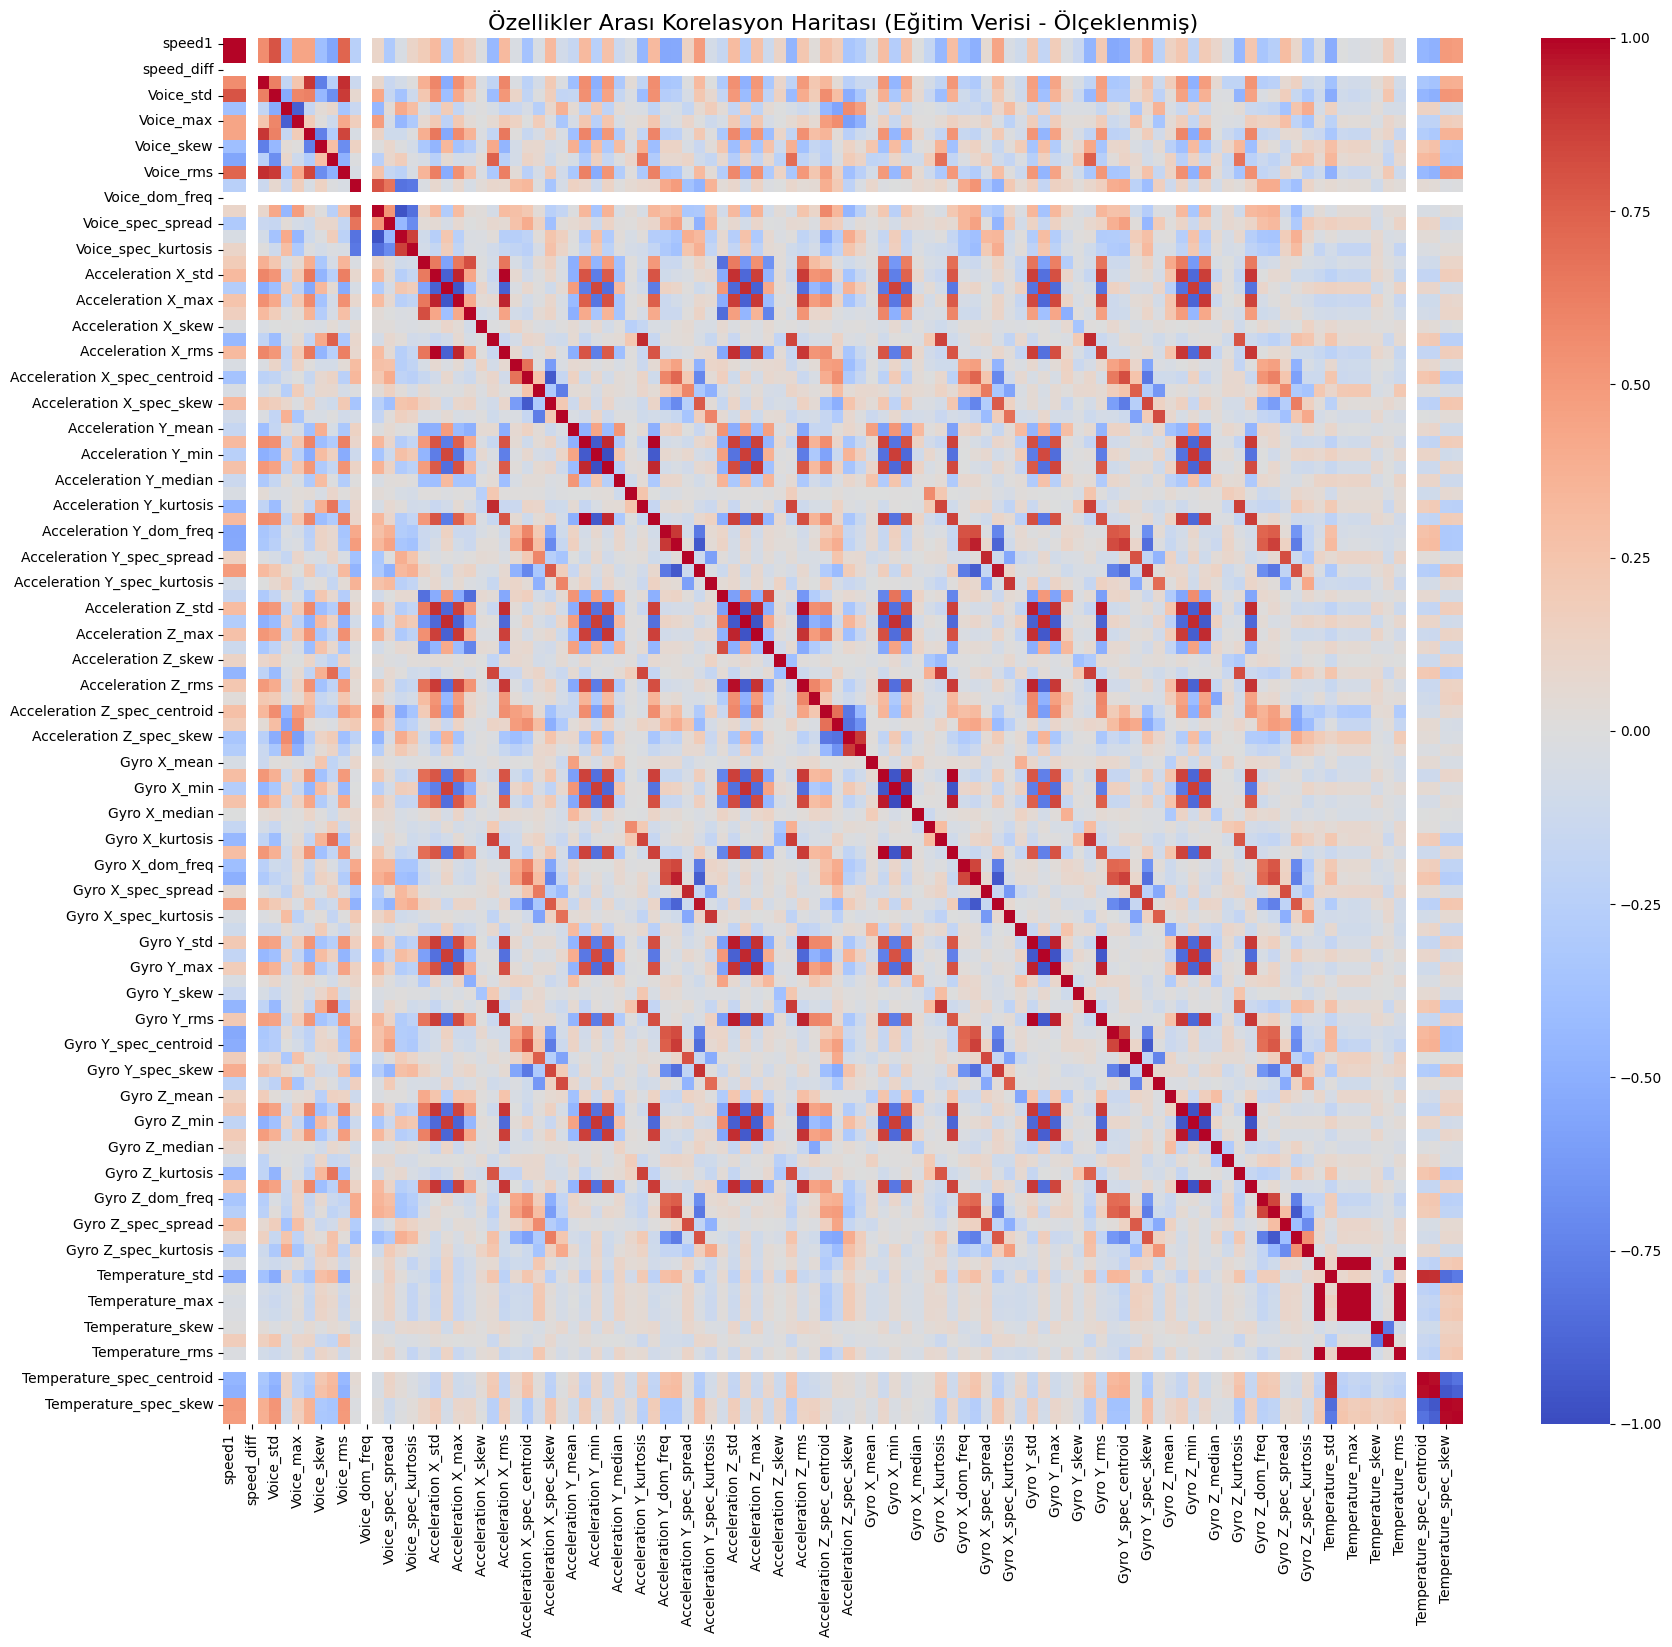


0.95 üzerinde mutlak korelasyona sahip en az bir başka özellikle ilişkili özellikler:
- speed2: ['speed1']
- Voice_spec_skew: ['Voice_spec_centroid']
- Acceleration X_max: ['Acceleration X_min']
- Acceleration X_rms: ['Acceleration X_std']
- Acceleration Y_max: ['Acceleration Y_min']
- Acceleration Y_rms: ['Acceleration Y_std']
- Acceleration Z_max: ['Acceleration Z_min']
- Acceleration Z_rms: ['Acceleration Z_std']
- Gyro X_min: ['Gyro X_std']
- Gyro X_max: ['Gyro X_std', 'Gyro X_min']
- Gyro X_rms: ['Gyro X_std', 'Gyro X_min', 'Gyro X_max']
- Gyro X_spec_skew: ['Acceleration Y_spec_skew']
- Gyro Y_std: ['Acceleration Z_std']
- Gyro Y_max: ['Gyro Y_min']
- Gyro Y_rms: ['Acceleration Z_std', 'Gyro Y_std']
- Gyro Z_min: ['Gyro Z_std']
- Gyro Z_max: ['Gyro Z_std', 'Gyro Z_min']
- Gyro Z_rms: ['Gyro Z_std', 'Gyro Z_min', 'Gyro Z_max']
- Temperature_min: ['Temperature_mean']
- Temperature_max: ['Temperature_mean', 'Temperature_min']
- Temperature_median: ['Temperature_mean', 'Temperature_

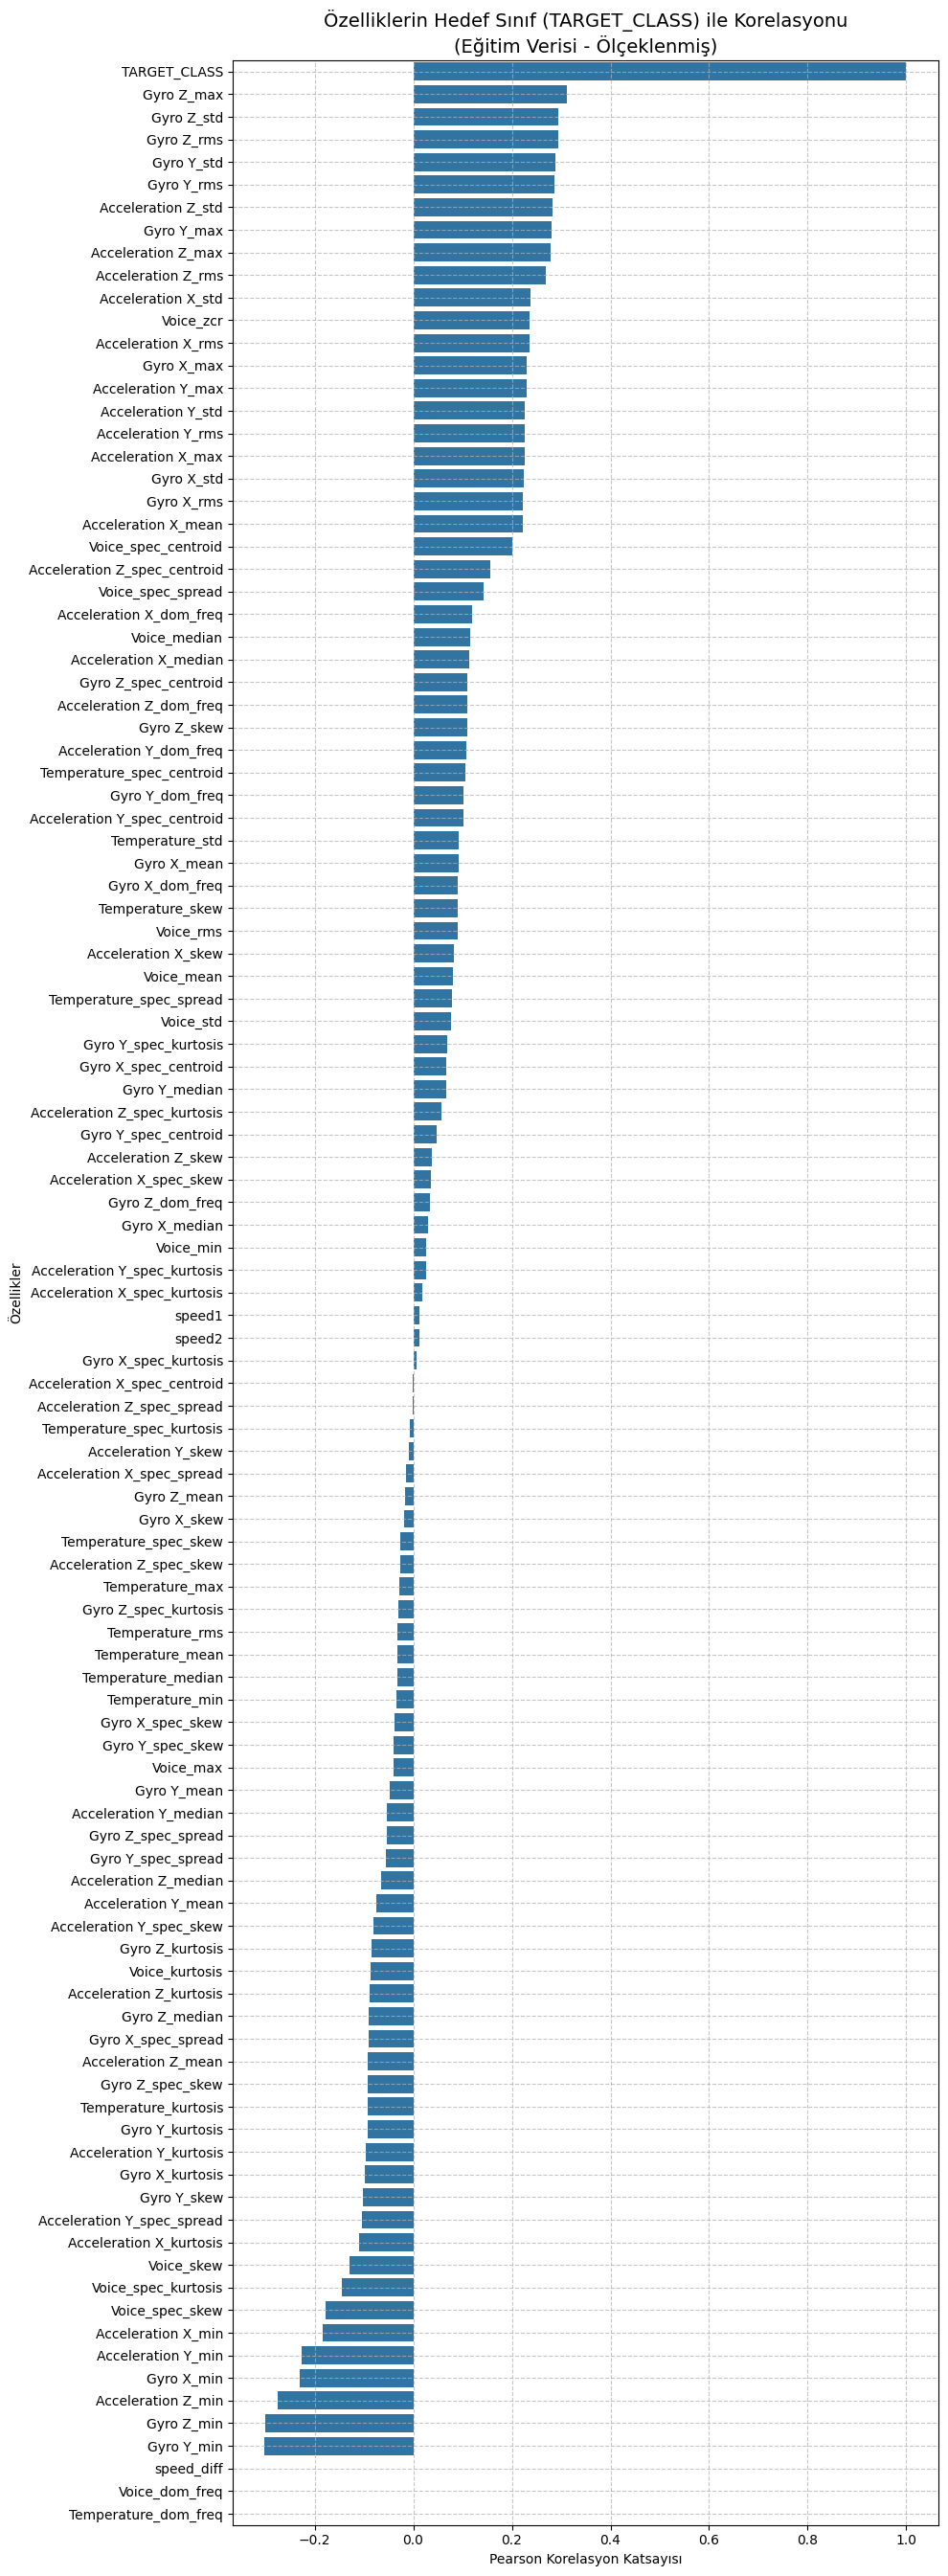


Hedef Sınıf ile En Yüksek Korelasyona Sahip İlk 10 Özellik:
TARGET_CLASS          1.000000
Gyro Z_max            0.312005
Gyro Z_std            0.294638
Gyro Z_rms            0.294061
Gyro Y_std            0.287584
Gyro Y_rms            0.287309
Acceleration Z_std    0.282931
Gyro Y_max            0.281205
Acceleration Z_max    0.278923
Acceleration Z_rms    0.269740
Name: TARGET_CLASS, dtype: float64

Hedef Sınıf ile En Düşük (En Negatif) Korelasyona Sahip İlk 10 Özellik:
Voice_spec_skew        -0.177673
Acceleration X_min     -0.184416
Acceleration Y_min     -0.226252
Gyro X_min             -0.230551
Acceleration Z_min     -0.274992
Gyro Z_min             -0.300647
Gyro Y_min             -0.301409
speed_diff                   NaN
Voice_dom_freq               NaN
Temperature_dom_freq         NaN
Name: TARGET_CLASS, dtype: float64


In [ ]:

X_train_df_scaled = pd.DataFrame(X_train, columns=feature_column_names)


correlation_matrix = X_train_df_scaled.corr()


plt.figure(figsize=(20, 18)) 
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Özellikler Arası Korelasyon Haritası (Eğitim Verisi - Ölçeklenmiş)', fontsize=16)
plt.show()


threshold = 0.95
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

print(f"\n{threshold} üzerinde mutlak korelasyona sahip en az bir başka özellikle ilişkili özellikler:")
for feature_col in highly_correlated_features:
    correlated_with = upper.index[abs(upper[feature_col]) > threshold].tolist()
    print(f"- {feature_col}: {correlated_with}")


X_train_df_scaled_with_target = X_train_df_scaled.copy()
X_train_df_scaled_with_target['TARGET_CLASS'] = y_train 

correlation_with_target = X_train_df_scaled_with_target.corr()['TARGET_CLASS'].sort_values(ascending=False)

plt.figure(figsize=(10, max(12, len(correlation_with_target) // 4))) 
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
plt.title('Özelliklerin Hedef Sınıf (TARGET_CLASS) ile Korelasyonu\n(Eğitim Verisi - Ölçeklenmiş)', fontsize=14)
plt.xlabel('Pearson Korelasyon Katsayısı')
plt.ylabel('Özellikler')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nHedef Sınıf ile En Yüksek Korelasyona Sahip İlk 10 Özellik:")
print(correlation_with_target.head(10))
print("\nHedef Sınıf ile En Düşük (En Negatif) Korelasyona Sahip İlk 10 Özellik:")
print(correlation_with_target.tail(10))

In [ ]:

speed_diff_std_train = X_train_df_scaled['speed_diff'].std()
print(f"\n'speed_diff' özelliğinin eğitim setindeki standart sapması: {speed_diff_std_train}")


voice_dom_freq_std_train = X_train_df_scaled['Voice_dom_freq'].std()
temp_dom_freq_std_train = X_train_df_scaled['Temperature_dom_freq'].std()
print(f"'Voice_dom_freq' özelliğinin eğitim setindeki standart sapması: {voice_dom_freq_std_train}")
print(f"'Temperature_dom_freq' özelliğinin eğitim setindeki standart sapması: {temp_dom_freq_std_train}")




speed_diff_original_std = pd.DataFrame(X_train_raw, columns=feature_column_names)['speed_diff'].std()
voice_dom_freq_original_std = pd.DataFrame(X_train_raw, columns=feature_column_names)['Voice_dom_freq'].std()
temp_dom_freq_original_std = pd.DataFrame(X_train_raw, columns=feature_column_names)['Temperature_dom_freq'].std()

print(f"\nOrijinal (ölçeklenmemiş) 'speed_diff' std: {speed_diff_original_std}") # Bunun 0 olması beklenir
print(f"Orijinal (ölçeklenmemiş) 'Voice_dom_freq' std: {voice_dom_freq_original_std}")
print(f"Orijinal (ölçeklenmemiş) 'Temperature_dom_freq' std: {temp_dom_freq_original_std}")


'speed_diff' özelliğinin eğitim setindeki standart sapması: 0.0
'Voice_dom_freq' özelliğinin eğitim setindeki standart sapması: 0.0
'Temperature_dom_freq' özelliğinin eğitim setindeki standart sapması: 0.0

Orijinal (ölçeklenmemiş) 'speed_diff' std: 0.0
Orijinal (ölçeklenmemiş) 'Voice_dom_freq' std: 0.0
Orijinal (ölçeklenmemiş) 'Temperature_dom_freq' std: 0.0


In [ ]:
# PLEASE DO NOT RUN THİS CELL.
models_params = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', multi_class='ovr', random_state=13, max_iter=1000), 
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'SVC': {
        'model': SVC(random_state=13, probability=True), 
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'] 
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=13),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(random_state=13),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        }
    }
}

results_list = []


cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)


for model_name, mp in models_params.items():
    print(f"\n--- {model_name} için GridSearchCV Başlatılıyor ---")
    
    grid_search = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=cv_stratified,
        scoring='accuracy',
        verbose=1, 
        n_jobs=-1 
    )
    
  
    start_train_time = time.time()
    grid_search.fit(X_train, y_train) 
    end_train_time = time.time()
    training_time = end_train_time - start_train_time
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_ 
    
    print(f"En İyi Parametreler ({model_name}): {best_params}")
    print(f"En İyi CV Skoru (Accuracy) ({model_name}): {best_cv_score:.4f}")
    
    
    start_test_time = time.time()
    y_pred = best_model.predict(X_test) 
    end_test_time = time.time()
    test_time = end_test_time - start_test_time
    
    test_accuracy = accuracy_score(y_test, y_pred)
    
    
    class_report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    
   
    model_results = {
        'Model': model_name,
        'Best_Params': best_params,
        'CV_Accuracy': best_cv_score,
        'Test_Accuracy': test_accuracy,
        'Training_Time (s)': training_time,
        'Test_Time (s)': test_time,
        'Classification_Report_Dict': class_report_dict
    }
    results_list.append(model_results)
    
    print(f"Test Accuracy ({model_name}): {test_accuracy:.4f}")
    print(f"Eğitim Süresi ({model_name}): {training_time:.2f} saniye")
    print(f"Test Süresi ({model_name}): {test_time:.4f} saniye")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



results_df = pd.DataFrame(results_list)


summary_results_list = []
for res in results_list:
    report = res['Classification_Report_Dict']
    summary_results_list.append({
        'Model': res['Model'],
        'CV Accuracy': f"{res['CV_Accuracy']:.4f}",
        'Test Accuracy': f"{report['accuracy']:.4f}", 
        'Macro Avg F1-Score': f"{report['macro avg']['f1-score']:.4f}",
        'Weighted Avg F1-Score': f"{report['weighted avg']['f1-score']:.4f}",
        'Training Time (s)': f"{res['Training_Time (s)']:.2f}",
        'Test Time (s)': f"{res['Test_Time (s)']:.4f}"
    })

summary_df = pd.DataFrame(summary_results_list)
print("\n\n--- Model Performans Karşılaştırma Özeti ---")
print(summary_df)


print("\n\n--- Her Sınıf İçin Detaylı Performans Metrikleri ---")
for res in results_list:
    print(f"\n===== {res['Model']} =====")
    print(f"Test Accuracy: {res['Classification_Report_Dict']['accuracy']:.4f}")
    print(f"Eğitim Süresi: {res['Training_Time (s)']:.2f} s, Test Süresi: {res['Test_Time (s)']:.4f} s")
    
    class_metrics_df = pd.DataFrame(res['Classification_Report_Dict']).transpose()
    
    relevant_indices = list(label_encoder.classes_) + ['macro avg', 'weighted avg']
    
    if 'accuracy' in class_metrics_df.index:
         class_metrics_df_display = class_metrics_df.loc[relevant_indices].copy()
    else: 
        class_metrics_df_display = class_metrics_df.loc[relevant_indices].copy()

    
    if 'support' in class_metrics_df_display.columns:
        class_metrics_df_display['support'] = class_metrics_df_display['support'].astype(int)
    
    print(class_metrics_df_display[['precision', 'recall', 'f1-score', 'support']])


--- LogisticRegression için GridSearchCV Başlatılıyor ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits
En İyi Parametreler (LogisticRegression): {'C': 10, 'penalty': 'l2'}
En İyi CV Skoru (Accuracy) (LogisticRegression): 0.6746
Test Accuracy (LogisticRegression): 0.6458
Eğitim Süresi (LogisticRegression): 18.00 saniye
Test Süresi (LogisticRegression): 0.0020 saniye
                precision    recall  f1-score   support

       healthy       0.82      0.88      0.85        48
     notchlong       0.43      0.50      0.46         6
    notchshort       0.20      0.17      0.18         6
       scracth       0.40      0.33      0.36         6
 singlecutlong       0.45      0.83      0.59         6
singlecutshort       0.60      0.50      0.55         6
    twocutlong       0.75      0.50      0.60         6
   twocutshort       0.60      0.50      0.55         6
        warped       0.00      0.00      0.00         6

      accuracy                           0.65      


In this step, I analyzed how the features relate to each other and also how they relate to the target class.

First, I created a correlation matrix using the scaled training data. Then I visualized it using a heatmap to see which features are strongly related (positively or negatively). This helps identify redundant features.

To find highly correlated features, I checked for pairs with a correlation above 0.95. These features might carry similar information and can sometimes be dropped or combined.

Next, I added the target class to the scaled feature dataframe and calculated how each feature correlates with the target using Pearson correlation. I plotted this using a barplot to see which features are most helpful for class prediction.

Finally, I printed the top 10 features that have the highest and lowest correlation with the target class. This gives an idea about which features might be most useful for the models.


In [16]:
if 'results_list' in locals():
    print(f"results_list içinde {len(results_list)} adet model sonucu var.")
    for result in results_list:
        print(f"Model: {result['Model']}, CV Accuracy: {result['CV_Accuracy']:.4f}, Test Accuracy: {result['Test_Accuracy']:.4f}")
else:
    print("results_list değişkeni bulunamadı.")

if 'summary_df' in locals():
    print("\nSummary DataFrame:")
    print(summary_df)
else:
    print("summary_df değişkeni bulunamadı.")

results_list içinde 5 adet model sonucu var.
Model: LogisticRegression, CV Accuracy: 0.6746, Test Accuracy: 0.6458
Model: KNeighborsClassifier, CV Accuracy: 0.6640, Test Accuracy: 0.7083
Model: SVC, CV Accuracy: 0.7136, Test Accuracy: 0.6354
Model: RandomForestClassifier, CV Accuracy: 0.8207, Test Accuracy: 0.8021
Model: GradientBoostingClassifier, CV Accuracy: 0.8337, Test Accuracy: 0.8125

Summary DataFrame:
                        Model CV Accuracy Test Accuracy Macro Avg F1-Score  \
0          LogisticRegression      0.6746        0.6458             0.4594   
1        KNeighborsClassifier      0.6640        0.7083             0.5223   
2                         SVC      0.7136        0.6354             0.5042   
3      RandomForestClassifier      0.8207        0.8021             0.7071   
4  GradientBoostingClassifier      0.8337        0.8125             0.7543   

  Weighted Avg F1-Score Training Time (s) Test Time (s)  
0                0.6296             18.00        0.0020  
1

In [17]:
if 'results_list' in locals():
    print(f"results_list içinde {len(results_list)} adet model sonucu var.\nİçerik:")
    for res_item in results_list:
        print(f"  Model: {res_item['Model']}, Test Accuracy: {res_item['Test_Accuracy']:.4f}")
else:
    print("results_list bulunamadı.")

results_list içinde 5 adet model sonucu var.
İçerik:
  Model: LogisticRegression, Test Accuracy: 0.6458
  Model: KNeighborsClassifier, Test Accuracy: 0.7083
  Model: SVC, Test Accuracy: 0.6354
  Model: RandomForestClassifier, Test Accuracy: 0.8021
  Model: GradientBoostingClassifier, Test Accuracy: 0.8125


In [ ]:

best_model_entry = None
best_accuracy = 0.0

for res in results_list:
    if res['Test_Accuracy'] > best_accuracy:
        best_accuracy = res['Test_Accuracy']
        best_model_entry = res



best_model_name = best_model_entry['Model']
best_model_params = best_model_entry['Best_Params']

print(f"\n--- En İyi Model Seçimi ---")
print(f"En iyi performansı gösteren model: {best_model_name}")
print(f"En iyi parametreleri: {best_model_params}")
print(f"Bu modelin test seti üzerindeki doğruluğu: {best_model_entry['Test_Accuracy']:.4f}")


final_model_instance = models_params[best_model_name]['model']
final_model_instance.set_params(**best_model_params) 

print(f"\n{best_model_name} modeli en iyi parametrelerle tüm eğitim verisi üzerinde yeniden eğitiliyor...")
final_model_instance.fit(X_train, y_train)
print("Yeniden eğitim tamamlandı.")


model_filename = f"{best_model_name.lower().replace(' ', '_')}_best_model.joblib"
joblib.dump(final_model_instance, model_filename)
print(f"En iyi model '{model_filename}' olarak kaydedildi.")


loaded_model = joblib.load(model_filename)
y_pred_loaded = loaded_model.predict(X_test)
loaded_model_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Kaydedilen modelin test doğruluğu: {loaded_model_accuracy:.4f} (Orijinal en iyi modelle aynı olmalı)")


print(f"\n--- {best_model_name} için Detaylı Sınıflandırma Raporu (Test Seti) ---")
best_model_report_dict = best_model_entry['Classification_Report_Dict']
print(classification_report(y_test, loaded_model.predict(X_test), target_names=label_encoder.classes_))


--- En İyi Model Seçimi ---
En iyi performansı gösteren model: GradientBoostingClassifier
En iyi parametreleri: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Bu modelin test seti üzerindeki doğruluğu: 0.8125

GradientBoostingClassifier modeli en iyi parametrelerle tüm eğitim verisi üzerinde yeniden eğitiliyor...
Yeniden eğitim tamamlandı.
En iyi model 'gradientboostingclassifier_best_model.joblib' olarak kaydedildi.
Kaydedilen modelin test doğruluğu: 0.8125 (Orijinal en iyi modelle aynı olmalı)

--- GradientBoostingClassifier için Detaylı Sınıflandırma Raporu (Test Seti) ---
                precision    recall  f1-score   support

       healthy       0.88      0.92      0.90        48
     notchlong       0.80      0.67      0.73         6
    notchshort       0.80      0.67      0.73         6
       scracth       0.44      0.67      0.53         6
 singlecutlong       0.56      0.83      0.67         6
singlecutshort       1.00      0.67      0.80         6
    twocut

<Figure size 1000x800 with 0 Axes>

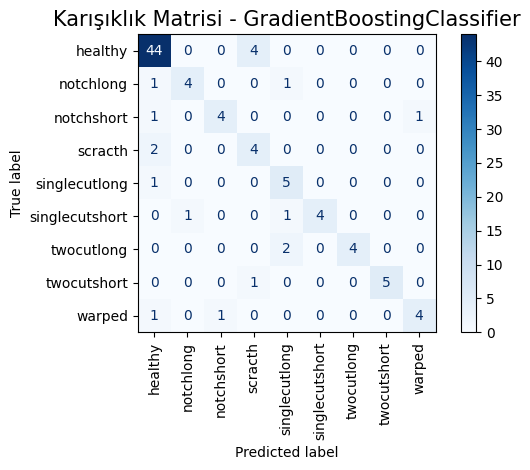

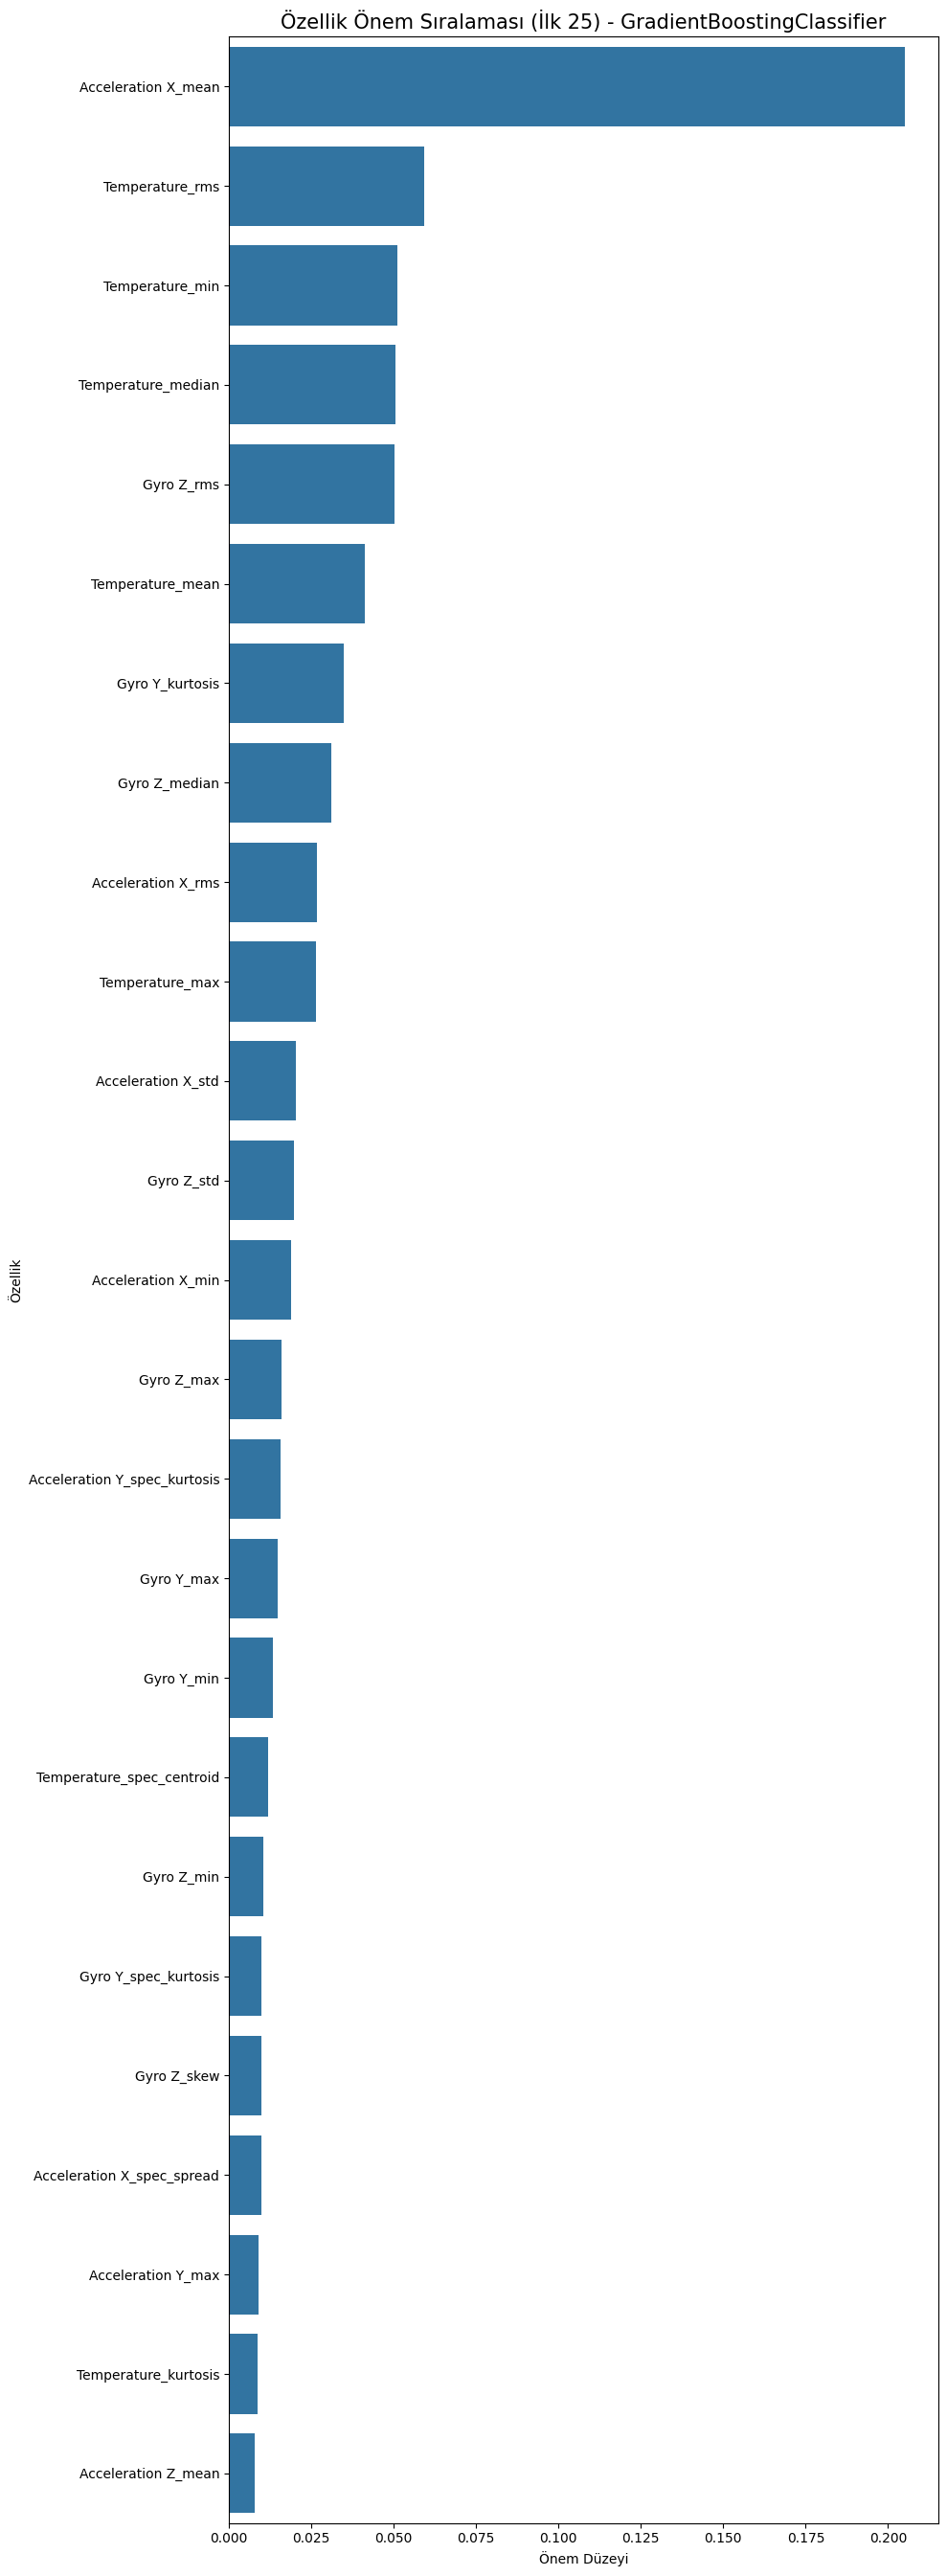


En Önemli 10 Özellik:
                 Feature  Importance
17   Acceleration X_mean    0.205015
102      Temperature_rms    0.059264
97       Temperature_min    0.051097
99    Temperature_median    0.050512
89            Gyro Z_rms    0.050341
95      Temperature_mean    0.041328
75       Gyro Y_kurtosis    0.034777
86         Gyro Z_median    0.031135
24    Acceleration X_rms    0.026825
98       Temperature_max    0.026603


In [ ]:


y_pred_best_model = final_model_instance.predict(X_test)



cm = confusion_matrix(y_test, y_pred_best_model, labels=final_model_instance.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.inverse_transform(final_model_instance.classes_))

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f'Karışıklık Matrisi - {best_model_name}', fontsize=15)
plt.tight_layout()
plt.show()



if hasattr(final_model_instance, 'feature_importances_'):
    importances = final_model_instance.feature_importances_
    
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_column_names, 
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, max(12, len(feature_importance_df) // 4))) 
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25))
    plt.title(f'Özellik Önem Sıralaması (İlk 25) - {best_model_name}', fontsize=15)
    plt.xlabel('Önem Düzeyi')
    plt.ylabel('Özellik')
    plt.tight_layout()
    plt.show()

    print("\nEn Önemli 10 Özellik:")
    print(feature_importance_df.head(10))
else:
    print(f"{best_model_name} modeli için özellik önem sıralaması doğrudan elde edilemiyor ('feature_importances_' attribute'u yok).")

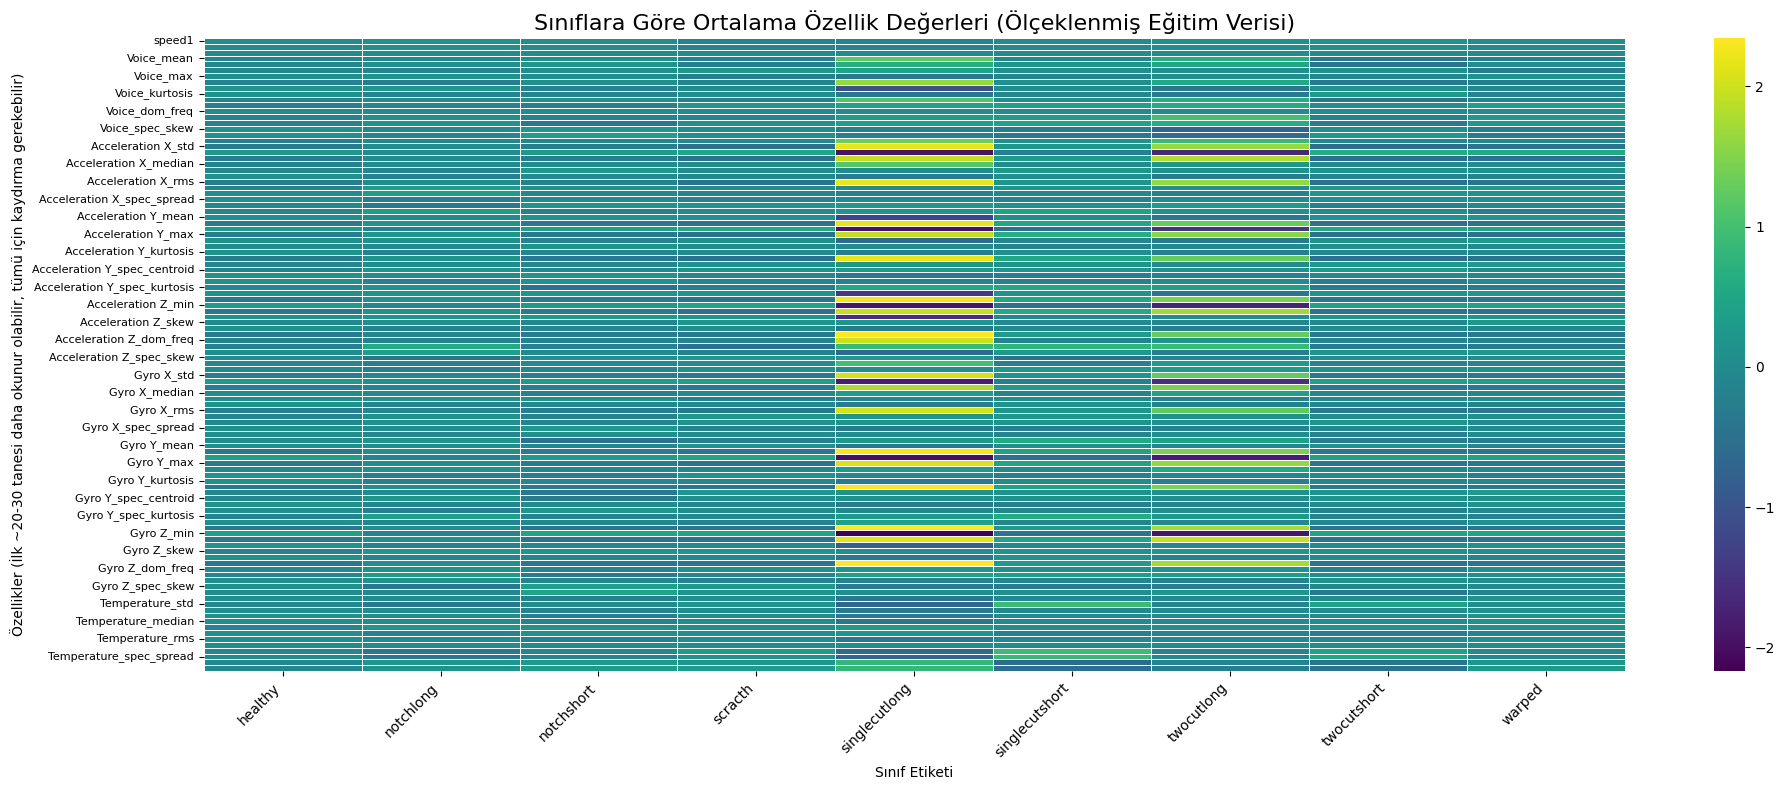

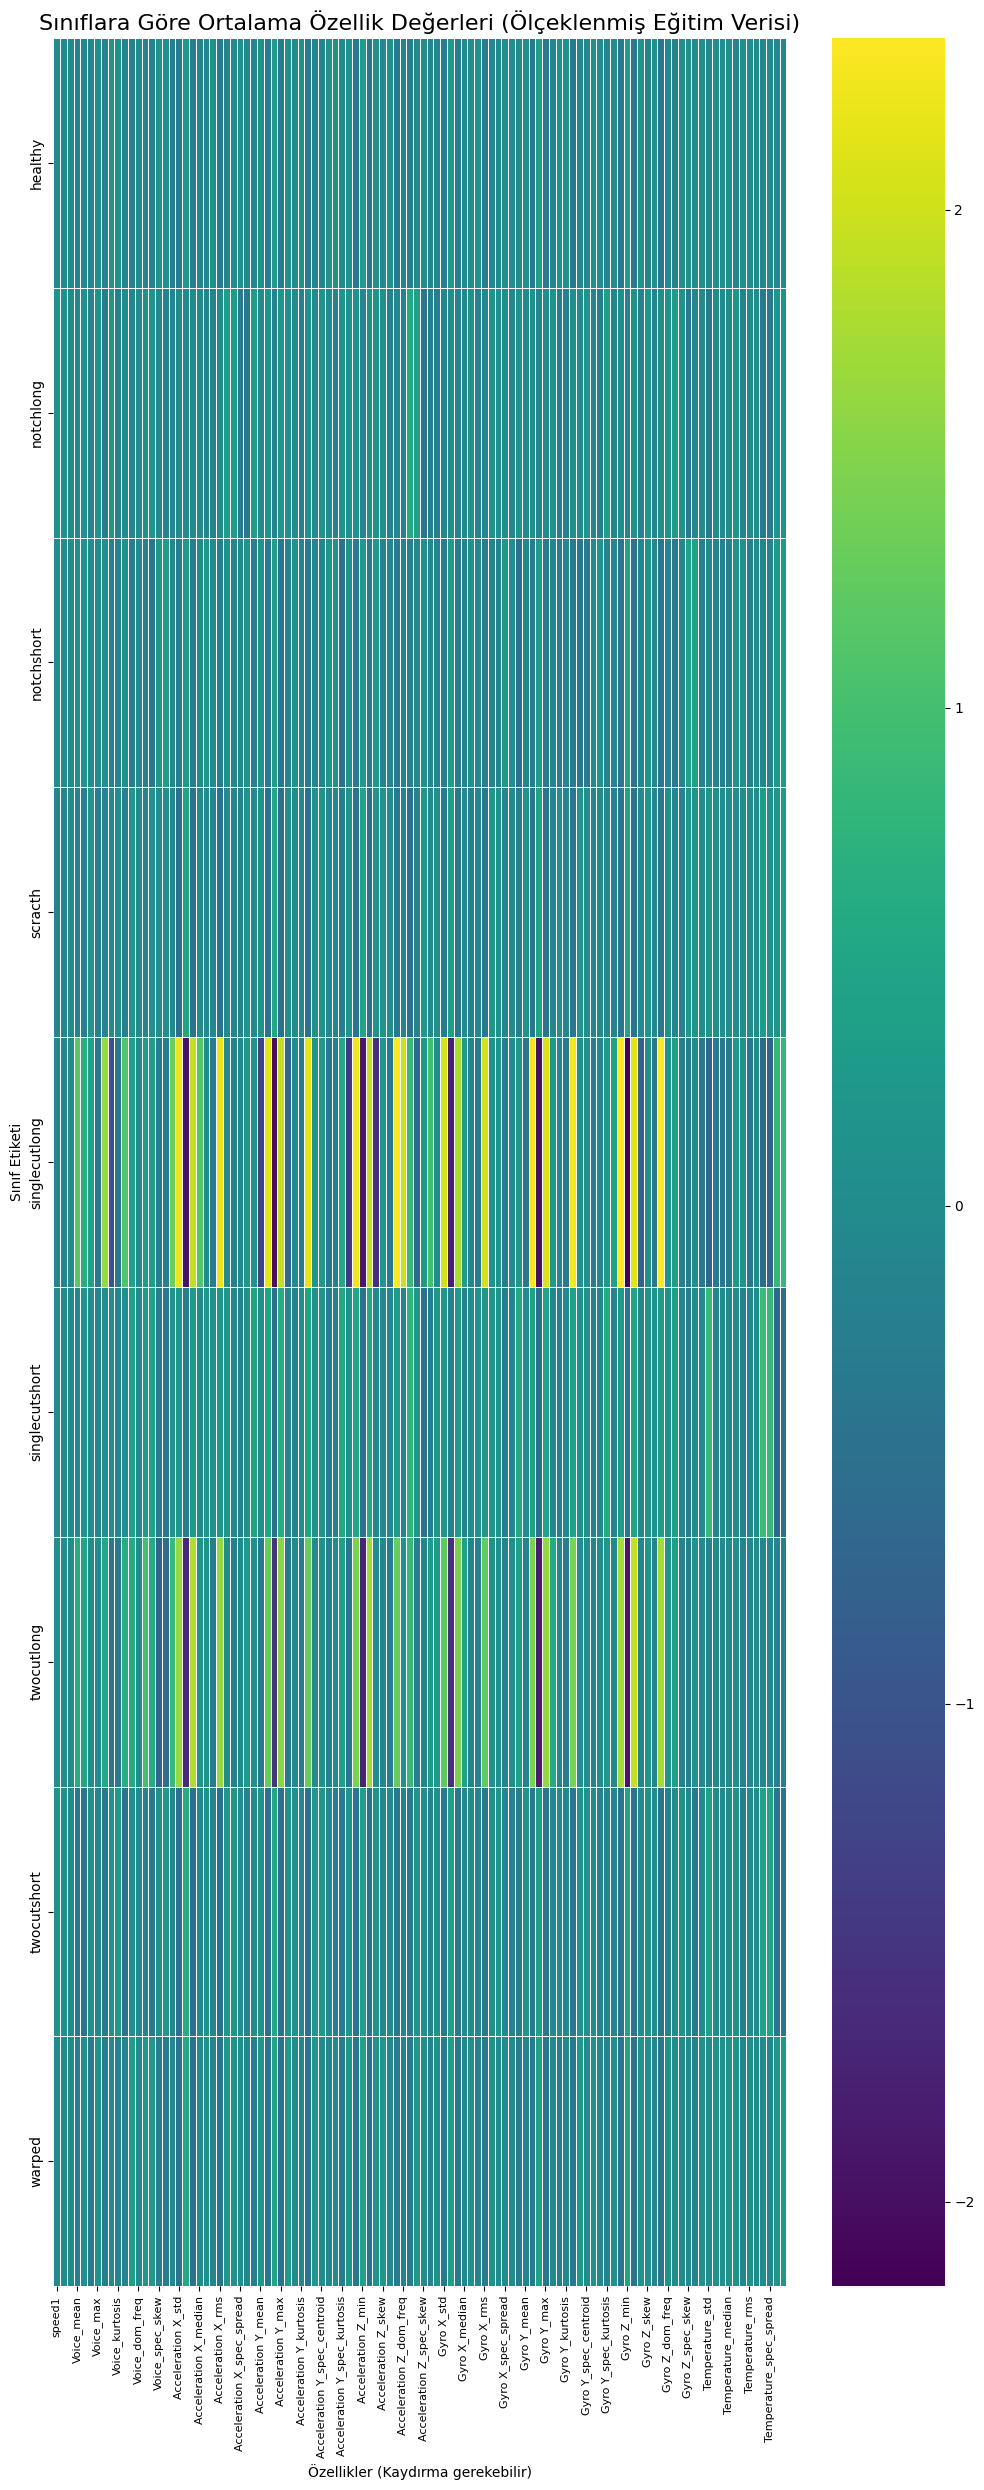

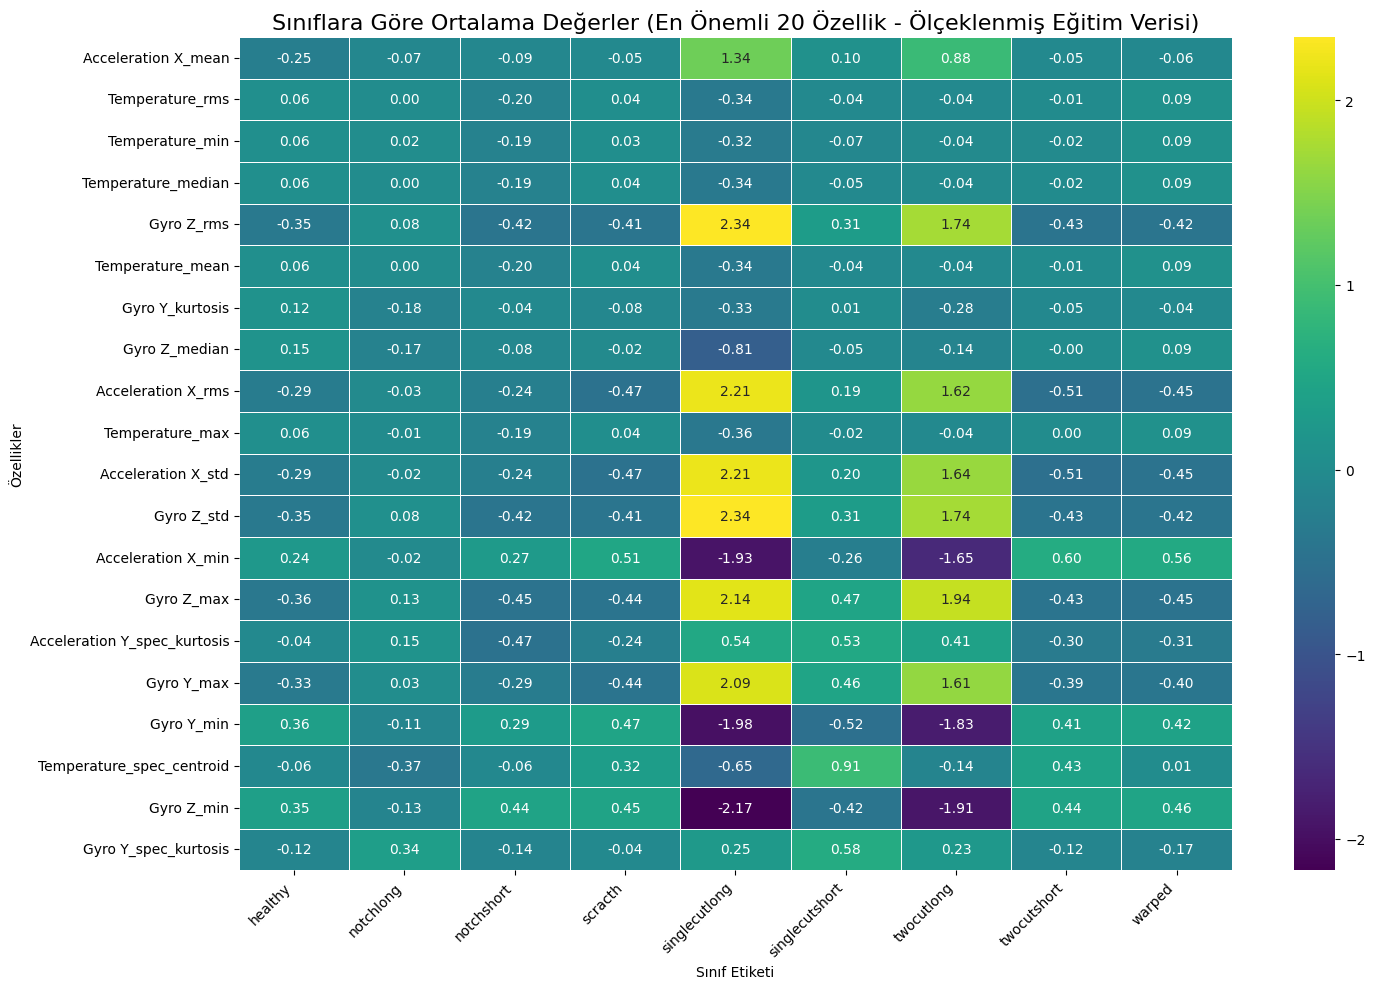

In [ ]:

X_train_df_for_heatmap = pd.DataFrame(X_train, columns=feature_column_names)
X_train_df_for_heatmap['Class_Encoded'] = y_train
X_train_df_for_heatmap['Class_Label'] = label_encoder.inverse_transform(y_train) 


class_mean_features = X_train_df_for_heatmap.groupby('Class_Label')[feature_column_names].mean()


plt.figure(figsize=(20, 8)) 
sns.heatmap(class_mean_features.T, annot=False, cmap="viridis", linewidths=.5)

plt.title('Sınıflara Göre Ortalama Özellik Değerleri (Ölçeklenmiş Eğitim Verisi)', fontsize=16)
plt.xlabel('Sınıf Etiketi')
plt.ylabel('Özellikler (İlk ~20-30 tanesi daha okunur olabilir, tümü için kaydırma gerekebilir)')
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=8) 
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 25)) 
sns.heatmap(class_mean_features, annot=False, cmap="viridis", linewidths=.5)
plt.title('Sınıflara Göre Ortalama Özellik Değerleri (Ölçeklenmiş Eğitim Verisi)', fontsize=16)
plt.xlabel('Özellikler (Kaydırma gerekebilir)')
plt.ylabel('Sınıf Etiketi')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()



if 'feature_importance_df' in locals() and not feature_importance_df.empty:
    top_n_features = feature_importance_df['Feature'].head(20).tolist()
    class_mean_top_features = X_train_df_for_heatmap.groupby('Class_Label')[top_n_features].mean()

    plt.figure(figsize=(15, 10))
    sns.heatmap(class_mean_top_features.T, annot=True, cmap="viridis", linewidths=.5, fmt=".2f")
    plt.title('Sınıflara Göre Ortalama Değerler (En Önemli 20 Özellik - Ölçeklenmiş Eğitim Verisi)', fontsize=16)
    plt.xlabel('Sınıf Etiketi')
    plt.ylabel('Özellikler')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Özellik önem sıralaması (feature_importance_df) bulunamadığından en önemli özelliklerle heatmap çizilemedi.")